# Imports


In [1]:
import os
import pandas as pd
import pickle
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
import time
import shap
import warnings
pd.set_option('display.max_columns', None)
# Suppress Matplotlib warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Load Data
- [Merge Admin Data with Diagnosis Data](#Merge-Admin-Data-with-Diagnosis-Data)
- [Rules](#Rules)
- [Chart Events](#Chart-Events)
- [Encoding](#Encoding)
- [Model Building](#Model-Building)
- [EDA](#EDA)



In [3]:
admissions_df = pd.read_csv('Data/admissions.csv')
d_icd_diagnoses = pd.read_csv('Data/d_icd_diagnoses.csv')
diagnosis_icd_df = pd.read_csv('Data/diagnoses_icd.csv')
patients_df = pd.read_csv('Data/patients.csv')
chartevents_df = pd.read_csv('Data/re_chart_events.csv')

print(admissions_df.shape, 'admissions_df')
display(admissions_df.head())
print(d_icd_diagnoses.shape, 'd_icd_diagnoses')
display(d_icd_diagnoses.head())
print(diagnosis_icd_df.shape, 'diagnosis_icd_df')
display(diagnosis_icd_df.head())
print(patients_df.shape, 'patients_df')
display(patients_df.head())
print(chartevents_df.shape, 'chartevents_df')
display(chartevents_df.head())

(431231, 16) admissions_df


,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P874LG,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaN,EW EMER.,P09Q6Y,EMERGENCY ROOM,HOME,Medicaid,ENGLISH,WIDOWED,WHITE,2180-06-26 15:54:00,2180-06-26 21:31:00,0
2,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,NaN,EW EMER.,P60CC5,EMERGENCY ROOM,HOSPICE,Medicaid,ENGLISH,WIDOWED,WHITE,2180-08-05 20:58:00,2180-08-06 01:44:00,0
3,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,NaN,EW EMER.,P30KEH,EMERGENCY ROOM,HOME,Medicaid,ENGLISH,WIDOWED,WHITE,2180-07-23 05:54:00,2180-07-23 14:00:00,0
4,10000068,25022803,2160-03-03 23:16:00,2160-03-04 06:26:00,NaN,EU OBSERVATION,P51VDL,EMERGENCY ROOM,NaN,Other,ENGLISH,SINGLE,WHITE,2160-03-03 21:55:00,2160-03-04 06:26:00,0


(109775, 3) d_icd_diagnoses


,icd_code,icd_version,long_title
0,0010,9,Cholera due to vibrio cholerae
1,0011,9,Cholera due to vibrio cholerae el tor
2,0019,9,"Cholera, unspecified"
3,0020,9,Typhoid fever
4,0021,9,Paratyphoid fever A


(4756326, 5) diagnosis_icd_df


,subject_id,hadm_id,seq_num,icd_code,icd_version
0,10000032,22595853,1,5723,9
1,10000032,22595853,2,78959,9
2,10000032,22595853,3,5715,9
3,10000032,22595853,4,07070,9
4,10000032,22595853,5,496,9


(299712, 6) patients_df


,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10000032,F,52,2180,2014 - 2016,2180-09-09
1,10000048,F,23,2126,2008 - 2010,NaN
2,10000068,F,19,2160,2008 - 2010,NaN
3,10000084,M,72,2160,2017 - 2019,2161-02-13
4,10000102,F,27,2136,2008 - 2010,NaN


(134354, 13) chartevents_df


,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning,label,max_chart_time
0,12633892,26749242,35517603,74261.0,28-09-14 9:00,28-09-14 9:14,220210,21,21.0,insp/min,0,Respiratory Rate,28-09-14 9:00
1,16751019,28171969,37725857,64542.0,07-11-25 16:00,07-11-25 16:35,220180,61,61.0,mmHg,0,Non Invasive Blood Pressure diastolic,07-11-25 16:00
2,13028012,23471437,30044052,46303.0,09-11-38 17:00,09-11-38 17:21,220045,103,103.0,bpm,0,Heart Rate,09-11-38 17:00
3,12988457,25880850,37601939,34043.0,18-02-56 21:01,18-02-56 21:06,220180,72,72.0,mmHg,0,Non Invasive Blood Pressure diastolic,18-02-56 21:01
4,13804408,26908606,31508846,83437.0,28-04-24 5:00,28-04-24 4:53,220181,97,97.0,mmHg,0,Non Invasive Blood Pressure mean,28-04-24 5:00


## Function to categorize ICD codes

In [4]:

def categorize_icd(icd):
    try:
        if 1 <= int(icd) <= 139:
            return 'Infectious and Parasitic Diseases'
        elif 140 <= int(icd) <= 239:
            return 'Neoplasms'
        elif 240 <= int(icd) <= 279:
            return 'Endocrine, Nutritional, and Metabolic Diseases'
        elif 280 <= int(icd) <= 289:
            return 'Diseases of the Blood and Blood-forming Organs'
        elif 290 <= int(icd) <= 319:
            return 'Mental Disorders'
        elif 320 <= int(icd) <= 389:
            return 'Diseases of the Nervous System and Sense Organs'
        elif 390 <= int(icd) <= 459:
            return 'Diseases of the Circulatory System'
        elif 460 <= int(icd) <= 519:
            return 'Diseases of the Respiratory System'
        elif 520 <= int(icd) <= 579:
            return 'Diseases of the Digestive System'
        elif 580 <= int(icd) <= 629:
            return 'Diseases of the Genitourinary System'
        elif 630 <= int(icd) <= 679:
            return 'Complications of Pregnancy, Childbirth, and the Puerperium'
        elif 680 <= int(icd) <= 709:
            return 'Diseases of the Skin and Subcutaneous Tissue'
        elif 710 <= int(icd) <= 739:
            return 'Diseases of the Musculoskeletal System and Connective Tissue'
        elif 740 <= int(icd) <= 759:
            return 'Congenital Anomalies'
        elif 760 <= int(icd) <= 779:
            return 'Certain Conditions Originating in the Perinatal Period'
        elif 780 <= int(icd) <= 799:
            return 'Symptoms, Signs, and Ill-defined Conditions'
        elif 800 <= int(icd) <= 999:
            return 'Injury and Poisoning'
        
    except ValueError:
        if icd[0] == 'A' or icd[0] == 'B':
            return 'Infectious and Parasitic Diseases'
        elif icd[0] == 'C':
            return 'Neoplasms'
        elif icd[0] == 'D':
            return 'Diseases of the Blood and Blood-forming Organs'
        elif icd[0] == 'E':
            return 'External causes of injury and supplemental classification'
        elif icd[0] == 'F':
            return 'Mental Disorders'
        elif icd[0] == 'G':
            return 'Diseases of the Nervous System and Sense Organs'
        elif icd[0] == 'H':
            return 'Diseases of the eye, adnexa and mastoid process'
        elif icd[0] == 'I':
            return 'Diseases of the Circulatory System'
        elif icd[0] == 'J':
            return 'Diseases of the Respiratory System'
        elif icd[0] == 'K':
            return 'Diseases of the Digestive System'
        elif icd[0] == 'L':
            return 'Diseases of the Skin and Subcutaneous Tissue'
        elif icd[0] == 'M':
            return 'Diseases of the Musculoskeletal System and Connective Tissue'
        elif icd[0] == 'N':
            return 'Diseases of the Genitourinary System'
        elif icd[0] == 'O':
            return 'Complications of Pregnancy, Childbirth, and the Puerperium'
        elif icd[0] == 'P':
            return 'Certain Conditions Originating in the Perinatal Period'
        elif icd[0] == 'Q':
            return 'Congenital Anomalies'
        elif icd[0] == 'R':
            return 'Symptoms, Signs, and Ill-defined Conditions'
        elif icd[0] == 'S' or icd[0] == 'T' :
            return 'Injury and Poisoning'
        elif icd[0] == 'U':
            return 'Codes for special purposes'
        elif icd[0] in ['V', 'W', 'X' ,'Y']:
            return 'External causes of injury and supplemental classification'
        elif icd[0] == 'Z':
            return 'Factors influencing health status and contact with health services'
 

## Recategorize Race

In [5]:

def categorize_race(admin_diag):
    ## Recategorize Race
    admin_diag['race'] = np.where(admin_diag['race'].isin(['AMERICAN INDIAN/ALASKA NATIVE']), 'AMERICAN INDIAN/ALASKA NATIVE',
                            np.where(admin_diag['race'].isin(['ASIAN', 'ASIAN - ASIAN INDIAN', 'ASIAN - CHINESE',
                                                                           'ASIAN - KOREAN', 'ASIAN - SOUTH EAST ASIAN']),
                                     'ASIAN',
                            np.where(admin_diag['race'].isin(['BLACK/AFRICAN', 'BLACK/AFRICAN AMERICAN', 
                                                                           'BLACK/CAPE VERDEAN', 'BLACK/CARIBBEAN ISLAND']),
                                     'BLACK/AFRICAN',
                            np.where(admin_diag['race'].isin(['HISPANIC OR LATINO', 'HISPANIC/LATINO - CENTRAL AMERICAN',
                                                                           'HISPANIC/LATINO - COLUMBIAN', 'HISPANIC/LATINO - CUBAN',
                                                                           'HISPANIC/LATINO - DOMINICAN', 'HISPANIC/LATINO - GUATEMALAN', 
                                                                           'HISPANIC/LATINO - HONDURAN', 'HISPANIC/LATINO - MEXICAN', 
                                                                           'HISPANIC/LATINO - PUERTO RICAN','HISPANIC/LATINO - SALVADORAN']), 
                                     'HISPANIC OR LATINO',
                            np.where(admin_diag['race'].isin(['NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER']), 
                                     'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER',
                            np.where(admin_diag['race'].isin(['MULTIPLE RACE/race', 'OTHER', 
                                                                      'PATIENT DECLINED TO ANSWER', 'UNABLE TO OBTAIN', 'UNKNOWN']), 
                                     'OTHER',
                            np.where(admin_diag['race'].isin(['PORTUGUESE']), 'PORTUGUESE',
                            np.where(admin_diag['race'].isin(['SOUTH AMERICAN']), 'SOUTH AMERICAN',
                            np.where(admin_diag['race'].isin(['WHITE', 'WHITE - BRAZILIAN', 'WHITE - EASTERN EUROPEAN',
                                                                           'WHITE - OTHER EUROPEAN', 'WHITE - RUSSIAN']), 
                                     'WHITE',
                                     np.nan)))))))))
    

    return admin_diag


In [6]:

diagnosis_icd_df['icd'] = diagnosis_icd_df.icd_code.str[:3]
diagnosis_icd_df['diagnosis'] = diagnosis_icd_df['icd'].apply(categorize_icd)
diagnosis_icd_df = diagnosis_icd_df[['subject_id', 'hadm_id', 'diagnosis']]
diagnosis_icd_df.head()

,subject_id,hadm_id,diagnosis
0,10000032,22595853,Diseases of the Digestive System
1,10000032,22595853,"Symptoms, Signs, and Ill-defined Conditions"
2,10000032,22595853,Diseases of the Digestive System
3,10000032,22595853,Infectious and Parasitic Diseases
4,10000032,22595853,Diseases of the Respiratory System


In [7]:
## Merge Diagnosis Data with Diagnosis Code(ICD)
patients_df = patients_df[['subject_id', 'gender', 'anchor_age']]
pat_diagn_data = pd.merge(diagnosis_icd_df, patients_df, on='subject_id', how='left')
pat_diagn_data.drop_duplicates(inplace=True)
pat_diagn_data.head()

,subject_id,hadm_id,diagnosis,gender,anchor_age
0,10000032,22595853,Diseases of the Digestive System,F,52
1,10000032,22595853,"Symptoms, Signs, and Ill-defined Conditions",F,52
3,10000032,22595853,Infectious and Parasitic Diseases,F,52
4,10000032,22595853,Diseases of the Respiratory System,F,52
5,10000032,22595853,Mental Disorders,F,52


In [8]:
print(pat_diagn_data.shape, 'diagnosis_data')

(2455128, 5) diagnosis_data


### ICD CODES

- 001–139: infectious and parasitic diseases
- 140–239: neoplasms
- 240–279: endocrine, nutritional and metabolic diseases, and immunity disorders
- 280–289: diseases of the blood and blood-forming organs
- 290–319: mental disorders
- 320–389: diseases of the nervous system and sense organs
- 390–459: diseases of the circulatory system
- 460–519: diseases of the respiratory system
- 520–579: diseases of the digestive system
- 580–629: diseases of the genitourinary system
- 630–679: complications of pregnancy, childbirth, and the puerperium
- 680–709: diseases of the skin and subcutaneous tissue
- 710–739: diseases of the musculoskeletal system and connective tissue
- 740–759: congenital anomalies
- 760–779: certain conditions originating in the perinatal period
- 780–799: symptoms, signs, and ill-defined conditions
- 800–999: injury and poisoning
- E and V codes: external causes of injury and supplemental classification


***Chapter	Block	Title***
- https://www.icd10data.com/ICD10CM/Codes
- I	A00–B99	Certain infectious and parasitic diseases
- II	C00–D48	Neoplasms
- III	D50–D89	Diseases of the blood and blood-forming organs and certain disorders involving the immune mechanism
- IV	E00–E90	Endocrine, nutritional and metabolic diseases
- V	F00–F99	Mental and behavioural disorders
- VI	G00–G99	Diseases of the nervous system
- VII	H00–H59	Diseases of the eye and adnexa
- VIII	H60–H95	Diseases of the ear and mastoid process
- IX	I00–I99	Diseases of the circulatory system
- X	J00–J99	Diseases of the respiratory system
- XI	K00–K93	Diseases of the digestive system
- XII	L00–L99	Diseases of the skin and subcutaneous tissue
- XIII	M00–M99	Diseases of the musculoskeletal system and connective tissue
- XIV	N00–N99	Diseases of the genitourinary system
- XV	O00–O99	Pregnancy, childbirth and the puerperium
- XVI	P00–P96	Certain conditions originating in the perinatal period
- XVII	Q00–Q99	Congenital malformations, deformations and chromosomal abnormalities
- XVIII	R00–R99	Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified
- XIX	S00–T98	Injury, poisoning and certain other consequences of external causes
- XX	V01–Y98	External causes of morbidity and mortality
- XXI	Z00–Z99	Factors influencing health status and contact with health services
- XXII	U00–U99	Codes for special purposes

#### Mapping of ICD Codes

In [9]:
pat_diagn_data.head(1)

,subject_id,hadm_id,diagnosis,gender,anchor_age
0,10000032,22595853,Diseases of the Digestive System,F,52


# Merge Admission Data with Diagnosis Data

In [10]:
admin_diag = pd.merge(admissions_df, pat_diagn_data, on=['subject_id','hadm_id'], 
                          how='left')
print(admin_diag.shape)
admin_diag.head()

(2455507, 19)


,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag,diagnosis,gender,anchor_age
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P874LG,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0,Diseases of the Digestive System,F,52.0
1,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P874LG,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0,"Symptoms, Signs, and Ill-defined Conditions",F,52.0
2,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P874LG,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0,Infectious and Parasitic Diseases,F,52.0
3,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P874LG,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0,Diseases of the Respiratory System,F,52.0
4,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P874LG,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0,Mental Disorders,F,52.0


In [11]:
## Select the required Columns
admin_diag = admin_diag[['subject_id', 'hadm_id', 'admittime','admission_type',
                         'admission_location','discharge_location', 'insurance', 
                         'language', 'marital_status', 'race',
                         'gender', 'anchor_age', 'diagnosis']]
admin_diag.head(2)

,subject_id,hadm_id,admittime,admission_type,admission_location,discharge_location,insurance,language,marital_status,race,gender,anchor_age,diagnosis
0,10000032,22595853,2180-05-06 22:23:00,URGENT,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,F,52.0,Diseases of the Digestive System
1,10000032,22595853,2180-05-06 22:23:00,URGENT,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,F,52.0,"Symptoms, Signs, and Ill-defined Conditions"


In [12]:
## Convert Time to Date
admin_diag['admittime'] = pd.to_datetime(admin_diag['admittime'])
admin_diag['admitdate'] = admin_diag['admittime'].dt.date

# Sort Values on the admin time
admin_diag.sort_values(['subject_id', 'admittime'], inplace=True)

## Get the time difference
admin_diag['admitdate_diff'] = admin_diag.groupby('subject_id')['admittime'].diff()

# Replace 0s with NaN
admin_diag['admitdate_diff'] = admin_diag['admitdate_diff'].replace(pd.Timedelta(0), np.nan)

# Forward fill NaN values
admin_diag['admitdate_diff'] = admin_diag['admitdate_diff'].fillna(method='ffill')
print(admin_diag.shape)
admin_diag.head()

(2455507, 15)


,subject_id,hadm_id,admittime,admission_type,admission_location,discharge_location,insurance,language,marital_status,race,gender,anchor_age,diagnosis,admitdate,admitdate_diff
0,10000032,22595853,2180-05-06 22:23:00,URGENT,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,F,52.0,Diseases of the Digestive System,2180-05-06,NaT
1,10000032,22595853,2180-05-06 22:23:00,URGENT,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,F,52.0,"Symptoms, Signs, and Ill-defined Conditions",2180-05-06,NaT
2,10000032,22595853,2180-05-06 22:23:00,URGENT,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,F,52.0,Infectious and Parasitic Diseases,2180-05-06,NaT
3,10000032,22595853,2180-05-06 22:23:00,URGENT,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,F,52.0,Diseases of the Respiratory System,2180-05-06,NaT
4,10000032,22595853,2180-05-06 22:23:00,URGENT,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,F,52.0,Mental Disorders,2180-05-06,NaT


In [13]:
# Define boolean conditions for each range
admin_diag['<30'] = admin_diag['admitdate_diff'] <= pd.Timedelta(days=30)
admin_diag['<60'] = (admin_diag['admitdate_diff'] <= pd.Timedelta(days=60))
admin_diag['>365'] = admin_diag['admitdate_diff'] > pd.Timedelta(days=365)

# Convert boolean values to integers (0 and 1)
admin_diag['<30'] = admin_diag['<30'].astype(int)
admin_diag['<60'] = admin_diag['<60'].astype(int)
admin_diag['>365'] = admin_diag['>365'].astype(int)
## Convert to Days
admin_diag['admitdate_diff'] = admin_diag['admitdate_diff'].dt.days
admin_diag.tail()

,subject_id,hadm_id,admittime,admission_type,admission_location,discharge_location,insurance,language,marital_status,race,gender,anchor_age,diagnosis,admitdate,admitdate_diff,<30,<60,>365
2455502,19999987,23865745,2145-11-02 21:38:00,EW EMER.,EMERGENCY ROOM,REHAB,Other,ENGLISH,NaN,UNKNOWN,F,57.0,Neoplasms,2145-11-02,47.0,0,1,0
2455503,19999987,23865745,2145-11-02 21:38:00,EW EMER.,EMERGENCY ROOM,REHAB,Other,ENGLISH,NaN,UNKNOWN,F,57.0,Diseases of the Genitourinary System,2145-11-02,47.0,0,1,0
2455504,19999987,23865745,2145-11-02 21:38:00,EW EMER.,EMERGENCY ROOM,REHAB,Other,ENGLISH,NaN,UNKNOWN,F,57.0,"Endocrine, Nutritional, and Metabolic Diseases",2145-11-02,47.0,0,1,0
2455505,19999987,23865745,2145-11-02 21:38:00,EW EMER.,EMERGENCY ROOM,REHAB,Other,ENGLISH,NaN,UNKNOWN,F,57.0,"Symptoms, Signs, and Ill-defined Conditions",2145-11-02,47.0,0,1,0
2455506,19999987,23865745,2145-11-02 21:38:00,EW EMER.,EMERGENCY ROOM,REHAB,Other,ENGLISH,NaN,UNKNOWN,F,57.0,Infectious and Parasitic Diseases,2145-11-02,47.0,0,1,0


In [14]:
admin_diag.shape

(2455507, 18)

In [15]:
admissions_df[admissions_df.subject_id==10000032]

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P874LG,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaN,EW EMER.,P09Q6Y,EMERGENCY ROOM,HOME,Medicaid,ENGLISH,WIDOWED,WHITE,2180-06-26 15:54:00,2180-06-26 21:31:00,0
2,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,NaN,EW EMER.,P60CC5,EMERGENCY ROOM,HOSPICE,Medicaid,ENGLISH,WIDOWED,WHITE,2180-08-05 20:58:00,2180-08-06 01:44:00,0
3,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,NaN,EW EMER.,P30KEH,EMERGENCY ROOM,HOME,Medicaid,ENGLISH,WIDOWED,WHITE,2180-07-23 05:54:00,2180-07-23 14:00:00,0


In [16]:
pat_diagn_data[(pat_diagn_data.subject_id==10000032) & (pat_diagn_data.hadm_id==22595853)][['subject_id','hadm_id','diagnosis']]

,subject_id,hadm_id,diagnosis
0,10000032,22595853,Diseases of the Digestive System
1,10000032,22595853,"Symptoms, Signs, and Ill-defined Conditions"
3,10000032,22595853,Infectious and Parasitic Diseases
4,10000032,22595853,Diseases of the Respiratory System
5,10000032,22595853,Mental Disorders
7,10000032,22595853,External causes of injury and supplemental cla...


In [17]:
round(pat_diagn_data.diagnosis.value_counts(normalize=True)*100)

diagnosis
External causes of injury and supplemental classification             13.0
Diseases of the Circulatory System                                    11.0
Symptoms, Signs, and Ill-defined Conditions                            8.0
Mental Disorders                                                       8.0
Diseases of the Digestive System                                       7.0
Endocrine, Nutritional, and Metabolic Diseases                         7.0
Diseases of the Nervous System and Sense Organs                        6.0
Diseases of the Genitourinary System                                   6.0
Diseases of the Blood and Blood-forming Organs                         5.0
Diseases of the Musculoskeletal System and Connective Tissue           5.0
Factors influencing health status and contact with health services     5.0
Diseases of the Respiratory System                                     5.0
Injury and Poisoning                                                   4.0
Infectious and 

In [18]:
pat_diagn_data.diagnosis.nunique()

20

# APPLIED RULES

In [19]:
## Recategorize Admission Type
conditions = admin_diag['admission_type'].isin(['EW EMER.', 'URGENT', 'DIRECT EMER.'])
admin_diag['admission_type'] = np.where(conditions, 'Emergency', admin_diag['admission_type'])

conditions = admin_diag['admission_type'].isin(['OBSERVATION ADMIT', 'EU OBSERVATION', 'DIRECT OBSERVATION', 'AMBULATORY OBSERVATION'])
admin_diag['admission_type'] = np.where(conditions, 'Observation', admin_diag['admission_type'])

conditions = admin_diag['admission_type'].isin(['SURGICAL SAME DAY ADMISSION'])
admin_diag['admission_type'] = np.where(conditions, 'Surgical Same Day Admission', admin_diag['admission_type'])

conditions = admin_diag['admission_type'].isin(['ELECTIVE'])
admin_diag['admission_type'] = np.where(conditions, 'Elective', admin_diag['admission_type'])


In [20]:
admin_diag.head(1)

,subject_id,hadm_id,admittime,admission_type,admission_location,discharge_location,insurance,language,marital_status,race,gender,anchor_age,diagnosis,admitdate,admitdate_diff,<30,<60,>365
0,10000032,22595853,2180-05-06 22:23:00,Emergency,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,F,52.0,Diseases of the Digestive System,2180-05-06,NaN,0,0,0


In [21]:
# CATEGPROIZE RACES
admin_diag = categorize_race(admin_diag)
admin_diag.shape

(2455507, 18)

# Merge Admission Data with Chart events

In [22]:
chartevents_df.columns

Index(['subject_id', 'hadm_id', 'stay_id', 'caregiver_id', 'charttime',
       'storetime', 'itemid', 'value', 'valuenum', 'valueuom', 'warning',
       'label', 'max_chart_time'],
      dtype='object')

In [23]:
master_merged = pd.merge(admin_diag, chartevents_df, on=['hadm_id','subject_id'], how='left')
# master_merged = master_merged.fillna(0)
print(master_merged.shape)
master_merged.head()

(3158797, 29)


,subject_id,hadm_id,admittime,admission_type,admission_location,discharge_location,insurance,language,marital_status,race,gender,anchor_age,diagnosis,admitdate,admitdate_diff,<30,<60,>365,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning,label,max_chart_time
0,10000032,22595853,2180-05-06 22:23:00,Emergency,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,F,52.0,Diseases of the Digestive System,2180-05-06,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10000032,22595853,2180-05-06 22:23:00,Emergency,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,F,52.0,"Symptoms, Signs, and Ill-defined Conditions",2180-05-06,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10000032,22595853,2180-05-06 22:23:00,Emergency,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,F,52.0,Infectious and Parasitic Diseases,2180-05-06,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10000032,22595853,2180-05-06 22:23:00,Emergency,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,F,52.0,Diseases of the Respiratory System,2180-05-06,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10000032,22595853,2180-05-06 22:23:00,Emergency,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,F,52.0,Mental Disorders,2180-05-06,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
print(master_merged[~master_merged['valuenum'].isna()].shape)
print(master_merged[master_merged['valuenum'].isna()].shape)

(1007002, 29)
(2151795, 29)


## Group patient label data with hospital admissions
- [Load Data](#Load-Data)
- [Rules](#Rules)
- [Chart Events](#Chart-Events)
- [Encoding](#Encoding)
- [Model Building](#Model-Building)
- [EDA](#EDA)


In [25]:
## Select the required columns
columns= ['subject_id', 'hadm_id', 'admittime', 'admission_type', 'admission_location',
          'insurance', 'language', 'marital_status', 'race','diagnosis', 'gender',
          'anchor_age','admitdate', 'admitdate_diff','valuenum', 'valueuom', 
          '<30', '<60', '>365']
master_merged = master_merged[columns]
master_merged.head(2)

,subject_id,hadm_id,admittime,admission_type,admission_location,insurance,language,marital_status,race,diagnosis,gender,anchor_age,admitdate,admitdate_diff,valuenum,valueuom,<30,<60,>365
0,10000032,22595853,2180-05-06 22:23:00,Emergency,TRANSFER FROM HOSPITAL,Other,ENGLISH,WIDOWED,WHITE,Diseases of the Digestive System,F,52.0,2180-05-06,NaN,NaN,NaN,0,0,0
1,10000032,22595853,2180-05-06 22:23:00,Emergency,TRANSFER FROM HOSPITAL,Other,ENGLISH,WIDOWED,WHITE,"Symptoms, Signs, and Ill-defined Conditions",F,52.0,2180-05-06,NaN,NaN,NaN,0,0,0


In [26]:
## Explode the columns which have the same values

explode_colomns = ['anchor_age', 'admission_type','gender','admission_location', 
                       'insurance', 'language', 'marital_status', 'race', 'diagnosis', 'admitdate_diff', '<30', '<60', '>365']
master_merged_df = master_merged.groupby(['subject_id', 'hadm_id','valuenum', 'valueuom'])[explode_colomns].agg(list).reset_index()

## Convert 'Nan' to NaN
master_merged_df['race'] = master_merged_df['race'].replace('nan', np.nan)
print(master_merged_df.shape)
master_merged_df.head()

(124373, 17)


,subject_id,hadm_id,valuenum,valueuom,anchor_age,admission_type,gender,admission_location,insurance,language,marital_status,race,diagnosis,admitdate_diff,<30,<60,>365
0,10000032,29079034,20.0,insp/min,"[52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0]","[Emergency, Emergency, Emergency, Emergency, E...","[F, F, F, F, F, F, F, F]","[EMERGENCY ROOM, EMERGENCY ROOM, EMERGENCY ROO...","[Medicaid, Medicaid, Medicaid, Medicaid, Medic...","[ENGLISH, ENGLISH, ENGLISH, ENGLISH, ENGLISH, ...","[WIDOWED, WIDOWED, WIDOWED, WIDOWED, WIDOWED, ...","[WHITE, WHITE, WHITE, WHITE, WHITE, WHITE, WHI...","[Diseases of the Circulatory System, Infectiou...","[26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0]","[1, 1, 1, 1, 1, 1, 1, 1]","[1, 1, 1, 1, 1, 1, 1, 1]","[0, 0, 0, 0, 0, 0, 0, 0]"
1,10000032,29079034,55.0,mmHg,"[52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0]","[Emergency, Emergency, Emergency, Emergency, E...","[F, F, F, F, F, F, F, F]","[EMERGENCY ROOM, EMERGENCY ROOM, EMERGENCY ROO...","[Medicaid, Medicaid, Medicaid, Medicaid, Medic...","[ENGLISH, ENGLISH, ENGLISH, ENGLISH, ENGLISH, ...","[WIDOWED, WIDOWED, WIDOWED, WIDOWED, WIDOWED, ...","[WHITE, WHITE, WHITE, WHITE, WHITE, WHITE, WHI...","[Diseases of the Circulatory System, Infectiou...","[26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0]","[1, 1, 1, 1, 1, 1, 1, 1]","[1, 1, 1, 1, 1, 1, 1, 1]","[0, 0, 0, 0, 0, 0, 0, 0]"
2,10000032,29079034,62.0,mmHg,"[52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0]","[Emergency, Emergency, Emergency, Emergency, E...","[F, F, F, F, F, F, F, F]","[EMERGENCY ROOM, EMERGENCY ROOM, EMERGENCY ROO...","[Medicaid, Medicaid, Medicaid, Medicaid, Medic...","[ENGLISH, ENGLISH, ENGLISH, ENGLISH, ENGLISH, ...","[WIDOWED, WIDOWED, WIDOWED, WIDOWED, WIDOWED, ...","[WHITE, WHITE, WHITE, WHITE, WHITE, WHITE, WHI...","[Diseases of the Circulatory System, Infectiou...","[26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0]","[1, 1, 1, 1, 1, 1, 1, 1]","[1, 1, 1, 1, 1, 1, 1, 1]","[0, 0, 0, 0, 0, 0, 0, 0]"
3,10000032,29079034,94.0,bpm,"[52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0]","[Emergency, Emergency, Emergency, Emergency, E...","[F, F, F, F, F, F, F, F]","[EMERGENCY ROOM, EMERGENCY ROOM, EMERGENCY ROO...","[Medicaid, Medicaid, Medicaid, Medicaid, Medic...","[ENGLISH, ENGLISH, ENGLISH, ENGLISH, ENGLISH, ...","[WIDOWED, WIDOWED, WIDOWED, WIDOWED, WIDOWED, ...","[WHITE, WHITE, WHITE, WHITE, WHITE, WHITE, WHI...","[Diseases of the Circulatory System, Infectiou...","[26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0]","[1, 1, 1, 1, 1, 1, 1, 1]","[1, 1, 1, 1, 1, 1, 1, 1]","[0, 0, 0, 0, 0, 0, 0, 0]"
4,10000032,29079034,95.0,%,"[52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0, 52.0]","[Emergency, Emergency, Emergency, Emergency, E...","[F, F, F, F, F, F, F, F]","[EMERGENCY ROOM, EMERGENCY ROOM, EMERGENCY ROO...","[Medicaid, Medicaid, Medicaid, Medicaid, Medic...","[ENGLISH, ENGLISH, ENGLISH, ENGLISH, ENGLISH, ...","[WIDOWED, WIDOWED, WIDOWED, WIDOWED, WIDOWED, ...","[WHITE, WHITE, WHITE, WHITE, WHITE, WHITE, WHI...","[Diseases of the Circulatory System, Infectiou...","[26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0]","[1, 1, 1, 1, 1, 1, 1, 1]","[1, 1, 1, 1, 1, 1, 1, 1]","[0, 0, 0, 0, 0, 0, 0, 0]"


In [27]:
# Apply the lambda function to each specified columnto get the unique value in the list
## This is to ensure same column have the unique value. eg. [EMERGENCY ROOM, EMERGENCY ROOM,....] to EMERGENCY ROOM
## Diagnosis is been considered because it may or may not have unique values.

for col in explode_colomns:
    if col!= 'diagnosis':
        master_merged_df[col] = master_merged_df[col].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None)


In [28]:
## Convert 'Nan' to NaN
master_merged_df['race'] = master_merged_df['race'].replace('nan', np.nan)

In [29]:
dummy_df = pd.get_dummies(master_merged_df['diagnosis'].explode(), prefix='diagnosis')
master_data = pd.concat([master_merged_df, dummy_df.groupby(level=0).max()], axis=1)
master_data.drop(columns=['diagnosis'], inplace=True)
print(master_data.shape)
master_data.tail()

(124373, 36)


,subject_id,hadm_id,valuenum,valueuom,anchor_age,admission_type,gender,admission_location,insurance,language,marital_status,race,admitdate_diff,<30,<60,>365,diagnosis_Certain Conditions Originating in the Perinatal Period,"diagnosis_Complications of Pregnancy, Childbirth, and the Puerperium",diagnosis_Congenital Anomalies,diagnosis_Diseases of the Blood and Blood-forming Organs,diagnosis_Diseases of the Circulatory System,diagnosis_Diseases of the Digestive System,diagnosis_Diseases of the Genitourinary System,diagnosis_Diseases of the Musculoskeletal System and Connective Tissue,diagnosis_Diseases of the Nervous System and Sense Organs,diagnosis_Diseases of the Respiratory System,diagnosis_Diseases of the Skin and Subcutaneous Tissue,"diagnosis_Diseases of the eye, adnexa and mastoid process","diagnosis_Endocrine, Nutritional, and Metabolic Diseases",diagnosis_External causes of injury and supplemental classification,diagnosis_Factors influencing health status and contact with health services,diagnosis_Infectious and Parasitic Diseases,diagnosis_Injury and Poisoning,diagnosis_Mental Disorders,diagnosis_Neoplasms,"diagnosis_Symptoms, Signs, and Ill-defined Conditions"
124368,19999287,22997012,72.0,mmHg,71.0,Emergency,F,EMERGENCY ROOM,Medicare,ENGLISH,SINGLE,BLACK/AFRICAN,2035.0,0,0,1,False,False,False,False,True,False,True,True,False,True,False,False,True,True,False,False,False,False,True,True
124369,19999287,22997012,83.0,mmHg,71.0,Emergency,F,EMERGENCY ROOM,Medicare,ENGLISH,SINGLE,BLACK/AFRICAN,2035.0,0,0,1,False,False,False,False,True,False,True,True,False,True,False,False,True,True,False,False,False,False,True,True
124370,19999442,26785317,99.9,°F,41.0,Elective,M,PHYSICIAN REFERRAL,Medicaid,ENGLISH,DIVORCED,WHITE,700.0,0,0,1,False,False,False,False,True,False,True,False,True,True,False,False,False,True,False,True,True,True,False,True
124371,19999987,23865745,107.0,mmHg,57.0,Emergency,F,EMERGENCY ROOM,Other,ENGLISH,NaN,OTHER,47.0,0,1,0,False,False,False,False,True,False,True,False,True,False,False,False,True,False,False,True,False,False,True,True
124372,19999987,23865745,116.0,mmHg,57.0,Emergency,F,EMERGENCY ROOM,Other,ENGLISH,NaN,OTHER,47.0,0,1,0,False,False,False,False,True,False,True,False,True,False,False,False,True,False,False,True,False,False,True,True


In [30]:
for i in ['valueuom', 'admission_type', 'gender', 'admission_location', 
             'insurance', 'language', 'marital_status', 'race'  ]:
    print(i, master_data[i].nunique())

valueuom 8
admission_type 4
gender 2
admission_location 11
insurance 3
language 2
marital_status 4
race 9


In [31]:
cat_columns=['valueuom', 'admission_type', 'gender', 'admission_location', 
             'insurance', 'language', 'marital_status', 'race'  ]


master_data = pd.get_dummies(master_data, columns=cat_columns, drop_first=True)
print(master_data.shape)
master_data.head()

(124373, 63)


,subject_id,hadm_id,valuenum,anchor_age,admitdate_diff,<30,<60,>365,diagnosis_Certain Conditions Originating in the Perinatal Period,"diagnosis_Complications of Pregnancy, Childbirth, and the Puerperium",diagnosis_Congenital Anomalies,diagnosis_Diseases of the Blood and Blood-forming Organs,diagnosis_Diseases of the Circulatory System,diagnosis_Diseases of the Digestive System,diagnosis_Diseases of the Genitourinary System,diagnosis_Diseases of the Musculoskeletal System and Connective Tissue,diagnosis_Diseases of the Nervous System and Sense Organs,diagnosis_Diseases of the Respiratory System,diagnosis_Diseases of the Skin and Subcutaneous Tissue,"diagnosis_Diseases of the eye, adnexa and mastoid process","diagnosis_Endocrine, Nutritional, and Metabolic Diseases",diagnosis_External causes of injury and supplemental classification,diagnosis_Factors influencing health status and contact with health services,diagnosis_Infectious and Parasitic Diseases,diagnosis_Injury and Poisoning,diagnosis_Mental Disorders,diagnosis_Neoplasms,"diagnosis_Symptoms, Signs, and Ill-defined Conditions",valueuom_bpm,valueuom_insp/min,valueuom_kg,valueuom_mg/dL,valueuom_mmHg,valueuom_units,valueuom_°F,admission_type_Emergency,admission_type_Observation,admission_type_Surgical Same Day Admission,gender_M,admission_location_CLINIC REFERRAL,admission_location_EMERGENCY ROOM,admission_location_INFORMATION NOT AVAILABLE,admission_location_INTERNAL TRANSFER TO OR FROM PSYCH,admission_location_PACU,admission_location_PHYSICIAN REFERRAL,admission_location_PROCEDURE SITE,admission_location_TRANSFER FROM HOSPITAL,admission_location_TRANSFER FROM SKILLED NURSING FACILITY,admission_location_WALK-IN/SELF REFERRAL,insurance_Medicare,insurance_Other,language_ENGLISH,marital_status_MARRIED,marital_status_SINGLE,marital_status_WIDOWED,race_ASIAN,race_BLACK/AFRICAN,race_HISPANIC OR LATINO,race_NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER,race_OTHER,race_PORTUGUESE,race_SOUTH AMERICAN,race_WHITE
0,10000032,29079034,20.0,52.0,26.0,1,1,0,False,False,False,False,True,True,False,False,False,True,False,False,True,True,False,True,False,True,False,True,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,True
1,10000032,29079034,55.0,52.0,26.0,1,1,0,False,False,False,False,True,True,False,False,False,True,False,False,True,True,False,True,False,True,False,True,False,False,False,False,True,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,True
2,10000032,29079034,62.0,52.0,26.0,1,1,0,False,False,False,False,True,True,False,False,False,True,False,False,True,True,False,True,False,True,False,True,False,False,False,False,True,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,True
3,10000032,29079034,94.0,52.0,26.0,1,1,0,False,False,False,False,True,True,False,False,False,True,False,False,True,True,False,True,False,True,False,True,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,True
4,10000032,29079034,95.0,52.0,26.0,1,1,0,False,False,False,False,True,True,False,False,False,True,False,False,True,True,False,True,False,True,False,True,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,True


In [32]:
print(master_data.shape)

(124373, 63)


# Model Building
- [Load Data](#Load-Data)
- [Merge Admin Data with Diagnosis Data](#Merge-Admin-Data-with-Diagnosis-Data)
- [Rules](#Rules)
- [Chart Events](#Chart-Events)
- [Encoding](#Encoding)
- [EDA](#EDA)


In [33]:
print(master_data.shape)
# master_data.dropna(subset=['admitdate_diff'], inplace=True)
# master_data.dropna(how='all',inplace=True)
master_data.dropna(inplace=True)
print(master_data.shape)


(124373, 63)
(124352, 63)


In [34]:
master_data.to_csv('Data/master_data.csv',index=False)

In [35]:
master_data.head(1)

,subject_id,hadm_id,valuenum,anchor_age,admitdate_diff,<30,<60,>365,diagnosis_Certain Conditions Originating in the Perinatal Period,"diagnosis_Complications of Pregnancy, Childbirth, and the Puerperium",diagnosis_Congenital Anomalies,diagnosis_Diseases of the Blood and Blood-forming Organs,diagnosis_Diseases of the Circulatory System,diagnosis_Diseases of the Digestive System,diagnosis_Diseases of the Genitourinary System,diagnosis_Diseases of the Musculoskeletal System and Connective Tissue,diagnosis_Diseases of the Nervous System and Sense Organs,diagnosis_Diseases of the Respiratory System,diagnosis_Diseases of the Skin and Subcutaneous Tissue,"diagnosis_Diseases of the eye, adnexa and mastoid process","diagnosis_Endocrine, Nutritional, and Metabolic Diseases",diagnosis_External causes of injury and supplemental classification,diagnosis_Factors influencing health status and contact with health services,diagnosis_Infectious and Parasitic Diseases,diagnosis_Injury and Poisoning,diagnosis_Mental Disorders,diagnosis_Neoplasms,"diagnosis_Symptoms, Signs, and Ill-defined Conditions",valueuom_bpm,valueuom_insp/min,valueuom_kg,valueuom_mg/dL,valueuom_mmHg,valueuom_units,valueuom_°F,admission_type_Emergency,admission_type_Observation,admission_type_Surgical Same Day Admission,gender_M,admission_location_CLINIC REFERRAL,admission_location_EMERGENCY ROOM,admission_location_INFORMATION NOT AVAILABLE,admission_location_INTERNAL TRANSFER TO OR FROM PSYCH,admission_location_PACU,admission_location_PHYSICIAN REFERRAL,admission_location_PROCEDURE SITE,admission_location_TRANSFER FROM HOSPITAL,admission_location_TRANSFER FROM SKILLED NURSING FACILITY,admission_location_WALK-IN/SELF REFERRAL,insurance_Medicare,insurance_Other,language_ENGLISH,marital_status_MARRIED,marital_status_SINGLE,marital_status_WIDOWED,race_ASIAN,race_BLACK/AFRICAN,race_HISPANIC OR LATINO,race_NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER,race_OTHER,race_PORTUGUESE,race_SOUTH AMERICAN,race_WHITE
0,10000032,29079034,20.0,52.0,26.0,1,1,0,False,False,False,False,True,True,False,False,False,True,False,False,True,True,False,True,False,True,False,True,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,True


In [36]:
master_data.columns

Index(['subject_id', 'hadm_id', 'valuenum', 'anchor_age', 'admitdate_diff',
       '<30', '<60', '>365',
       'diagnosis_Certain Conditions Originating in the Perinatal Period',
       'diagnosis_Complications of Pregnancy, Childbirth, and the Puerperium',
       'diagnosis_Congenital Anomalies',
       'diagnosis_Diseases of the Blood and Blood-forming Organs',
       'diagnosis_Diseases of the Circulatory System',
       'diagnosis_Diseases of the Digestive System',
       'diagnosis_Diseases of the Genitourinary System',
       'diagnosis_Diseases of the Musculoskeletal System and Connective Tissue',
       'diagnosis_Diseases of the Nervous System and Sense Organs',
       'diagnosis_Diseases of the Respiratory System',
       'diagnosis_Diseases of the Skin and Subcutaneous Tissue',
       'diagnosis_Diseases of the eye, adnexa and mastoid process',
       'diagnosis_Endocrine, Nutritional, and Metabolic Diseases',
       'diagnosis_External causes of injury and supplemental cla

In [37]:
X = master_data.drop(['subject_id', 'hadm_id', 'admitdate_diff','<30', '<60', '>365'], axis=1)

Y_30 = master_data['<30']
Y_60 = master_data['<60']
Y_365 = master_data['>365']
print(Y_30.shape, Y_60.shape, Y_365.shape)
X.shape

(124352,) (124352,) (124352,)


(124352, 57)

In [38]:
X.columns

Index(['valuenum', 'anchor_age',
       'diagnosis_Certain Conditions Originating in the Perinatal Period',
       'diagnosis_Complications of Pregnancy, Childbirth, and the Puerperium',
       'diagnosis_Congenital Anomalies',
       'diagnosis_Diseases of the Blood and Blood-forming Organs',
       'diagnosis_Diseases of the Circulatory System',
       'diagnosis_Diseases of the Digestive System',
       'diagnosis_Diseases of the Genitourinary System',
       'diagnosis_Diseases of the Musculoskeletal System and Connective Tissue',
       'diagnosis_Diseases of the Nervous System and Sense Organs',
       'diagnosis_Diseases of the Respiratory System',
       'diagnosis_Diseases of the Skin and Subcutaneous Tissue',
       'diagnosis_Diseases of the eye, adnexa and mastoid process',
       'diagnosis_Endocrine, Nutritional, and Metabolic Diseases',
       'diagnosis_External causes of injury and supplemental classification',
       'diagnosis_Factors influencing health status and co

In [39]:
X.shape

(124352, 57)

### 30 Days

In [40]:
t1= time.time()
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y_30, test_size=0.2, random_state=42)

# Initialize the Random Forest Classifier
model_30 = RandomForestClassifier(n_estimators=100, random_state=42)  # You can adjust the number of estimators as needed

# Train the model
model_30.fit(X_train, y_train)

# Predict on the test set
predictions_30 = model_30.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions_30)
print(f"Accuracy: {accuracy}")
print('Time: ', round((time.time()-t1)))

Accuracy: 0.9168107434361304
Time:  23


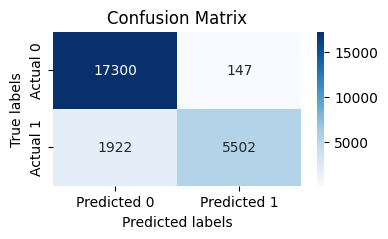

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.99      0.94     17447
           1       0.97      0.74      0.84      7424

    accuracy                           0.92     24871
   macro avg       0.94      0.87      0.89     24871
weighted avg       0.92      0.92      0.91     24871



In [41]:
cm = confusion_matrix(y_test, predictions_30)

# Display confusion matrix as a heatmap
plt.figure(figsize=(4, 2))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
# Generate classification report
report_30 = classification_report(y_test, predictions_30)
# Print the classification report
print("Classification Report:\n", report_30)


In [42]:
X_test.shape

(24871, 57)

In [43]:
X_test.head(2).values

array([[116.0, 66.0, False, False, False, True, True, False, False,
        False, True, True, True, False, False, True, True, True, False,
        True, False, True, True, False, False, False, False, False,
        False, True, False, False, False, False, False, False, False,
        False, False, False, True, False, False, True, False, True, True,
        False, False, False, False, False, False, False, False, False,
        True],
       [58.0, 48.0, False, False, False, False, True, True, False, False,
        True, True, False, False, True, True, False, False, False, True,
        False, False, False, False, False, False, True, False, False,
        True, False, False, True, False, False, False, False, False,
        False, False, True, False, False, False, True, True, True, False,
        False, False, False, False, False, False, False, False, True]],
      dtype=object)

### 60 Days

In [45]:
t1= time.time()

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y_60, test_size=0.2, random_state=42)

# Initialize the Random Forest Classifier
model_60 = RandomForestClassifier(n_estimators=100, random_state=42)  # You can adjust the number of estimators as needed

# Train the model
model_60.fit(X_train, y_train)

# Predict on the test set
predictions_60 = model_60.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions_60)
print(f"Accuracy: {accuracy}")

# Print the classification report
report_60 = classification_report(y_test, predictions_60)
print("Classification Report:\n", report_60)

print('Time: ', round(time.time()-t1)/60)

Accuracy: 0.9244501628402557
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.97      0.94     14313
           1       0.95      0.87      0.91     10558

    accuracy                           0.92     24871
   macro avg       0.93      0.92      0.92     24871
weighted avg       0.93      0.92      0.92     24871

Time:  0.4


### 365 Days

In [47]:
t1= time.time()

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y_365, test_size=0.2, random_state=42)

# Initialize the Random Forest Classifier
model_365 = RandomForestClassifier(n_estimators=100, random_state=42)  # You can adjust the number of estimators as needed

# Train the model
model_365.fit(X_train, y_train)

# Predict on the test set
predictions_365 = model_365.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions_365)
print(f"Accuracy: {accuracy}")

# Print the classification report
report_365 = classification_report(y_test, predictions_365)
print("Classification Report:\n", report_365)

print('Time: ', round(time.time()-t1)/60)

Accuracy: 0.9250130674279281
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.99      0.95     17724
           1       0.98      0.76      0.85      7147

    accuracy                           0.93     24871
   macro avg       0.94      0.87      0.90     24871
weighted avg       0.93      0.93      0.92     24871

Time:  0.36666666666666664


## Convert to Pickle and Tar.gz

In [55]:
# Save the dictionary containing all models into a single file using pickle
with open('Models/model_30.pkl', 'wb') as file:
    pickle.dump(model_30, file)
print('Model 30 Done')

# Save the dictionary containing all models into a single file using pickle
with open('Models/model_60.pkl', 'wb') as file:
    pickle.dump(model_60, file)
print('Model 60 Done')
    
# Save the dictionary containing all models into a single file using pickle
with open('Models/model_365.pkl', 'wb') as file:
    pickle.dump(model_365, file)
print('Model 365 Done')

In [63]:
import joblib
# Save the dictionary containing all models into a single file using pickle
with open('Models/model_30.joblib', 'wb') as file:
    joblib.dump(model_30, file)
print('Model 30 Done')


Model 30 Done


In [65]:
import tarfile
with tarfile.open('Models/model_30.tar.gz', 'w:gz') as tar:
    tar.add('Models/model_30.joblib')
print('Model 30 Done')

Model 30 Done


In [ ]:
import tarfile

with tarfile.open('Models/model_30.tar.gz', 'w:gz') as tar:
    tar.add('Models/model_30.pkl')
print('Model 30 Done')
    
with tarfile.open('Models/model_60.tar.gz', 'w:gz') as tar:
    tar.add('Models/model_60.pkl')
print('Model 60 Done')

with tarfile.open('Models/model_365.tar.gz', 'w:gz') as tar:
    tar.add('Models/model_365.pkl')
print('Model 365 Done')

In [60]:
# Create a dictionary to store all the models
models_dict = {
    '30_days': model_30,
    '60_days': model_60,
    '365_days': model_365
}

# Save the dictionary containing all models into a single file using pickle
with open('Models/readmission_model.pkl', 'wb') as file:
    pickle.dump(models_dict, file)
print('Readmission Model Done')

with tarfile.open('Models/readmission_model.tar.gz', 'w:gz') as tar:
    tar.add('Models/readmission_model.pkl')
print('Readmission Model Archived')

Readmission Model Done
Readmission Model Archived


In [58]:
with tarfile.open('Models/readmission_model.tar.gz', 'w:gz') as tar:
    tar.add('Models/readmission_model.pkl')